# Visit-to-Visit Single star PSF

In [1]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

def get_astropy_wcs(image):
    from astropy.wcs import WCS
    print(image.getWcs())
    
    wcs_dict = dict()
    for val in image.getWcs().getFitsMetadata():
        wcs_dict[str(val)] = image.getWcs().getFitsMetadata()[str(val)]

    return WCS(wcs_dict)

##### First we are going to setup a butler to repository where the LATISS data is ingested on USDF.<br>Here wea re just going to pull some raw images from a specific date and time.

##### You can look up on Rubin TV to check which date, or copy the dataID for a specific exposure.<br>
https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-05-23

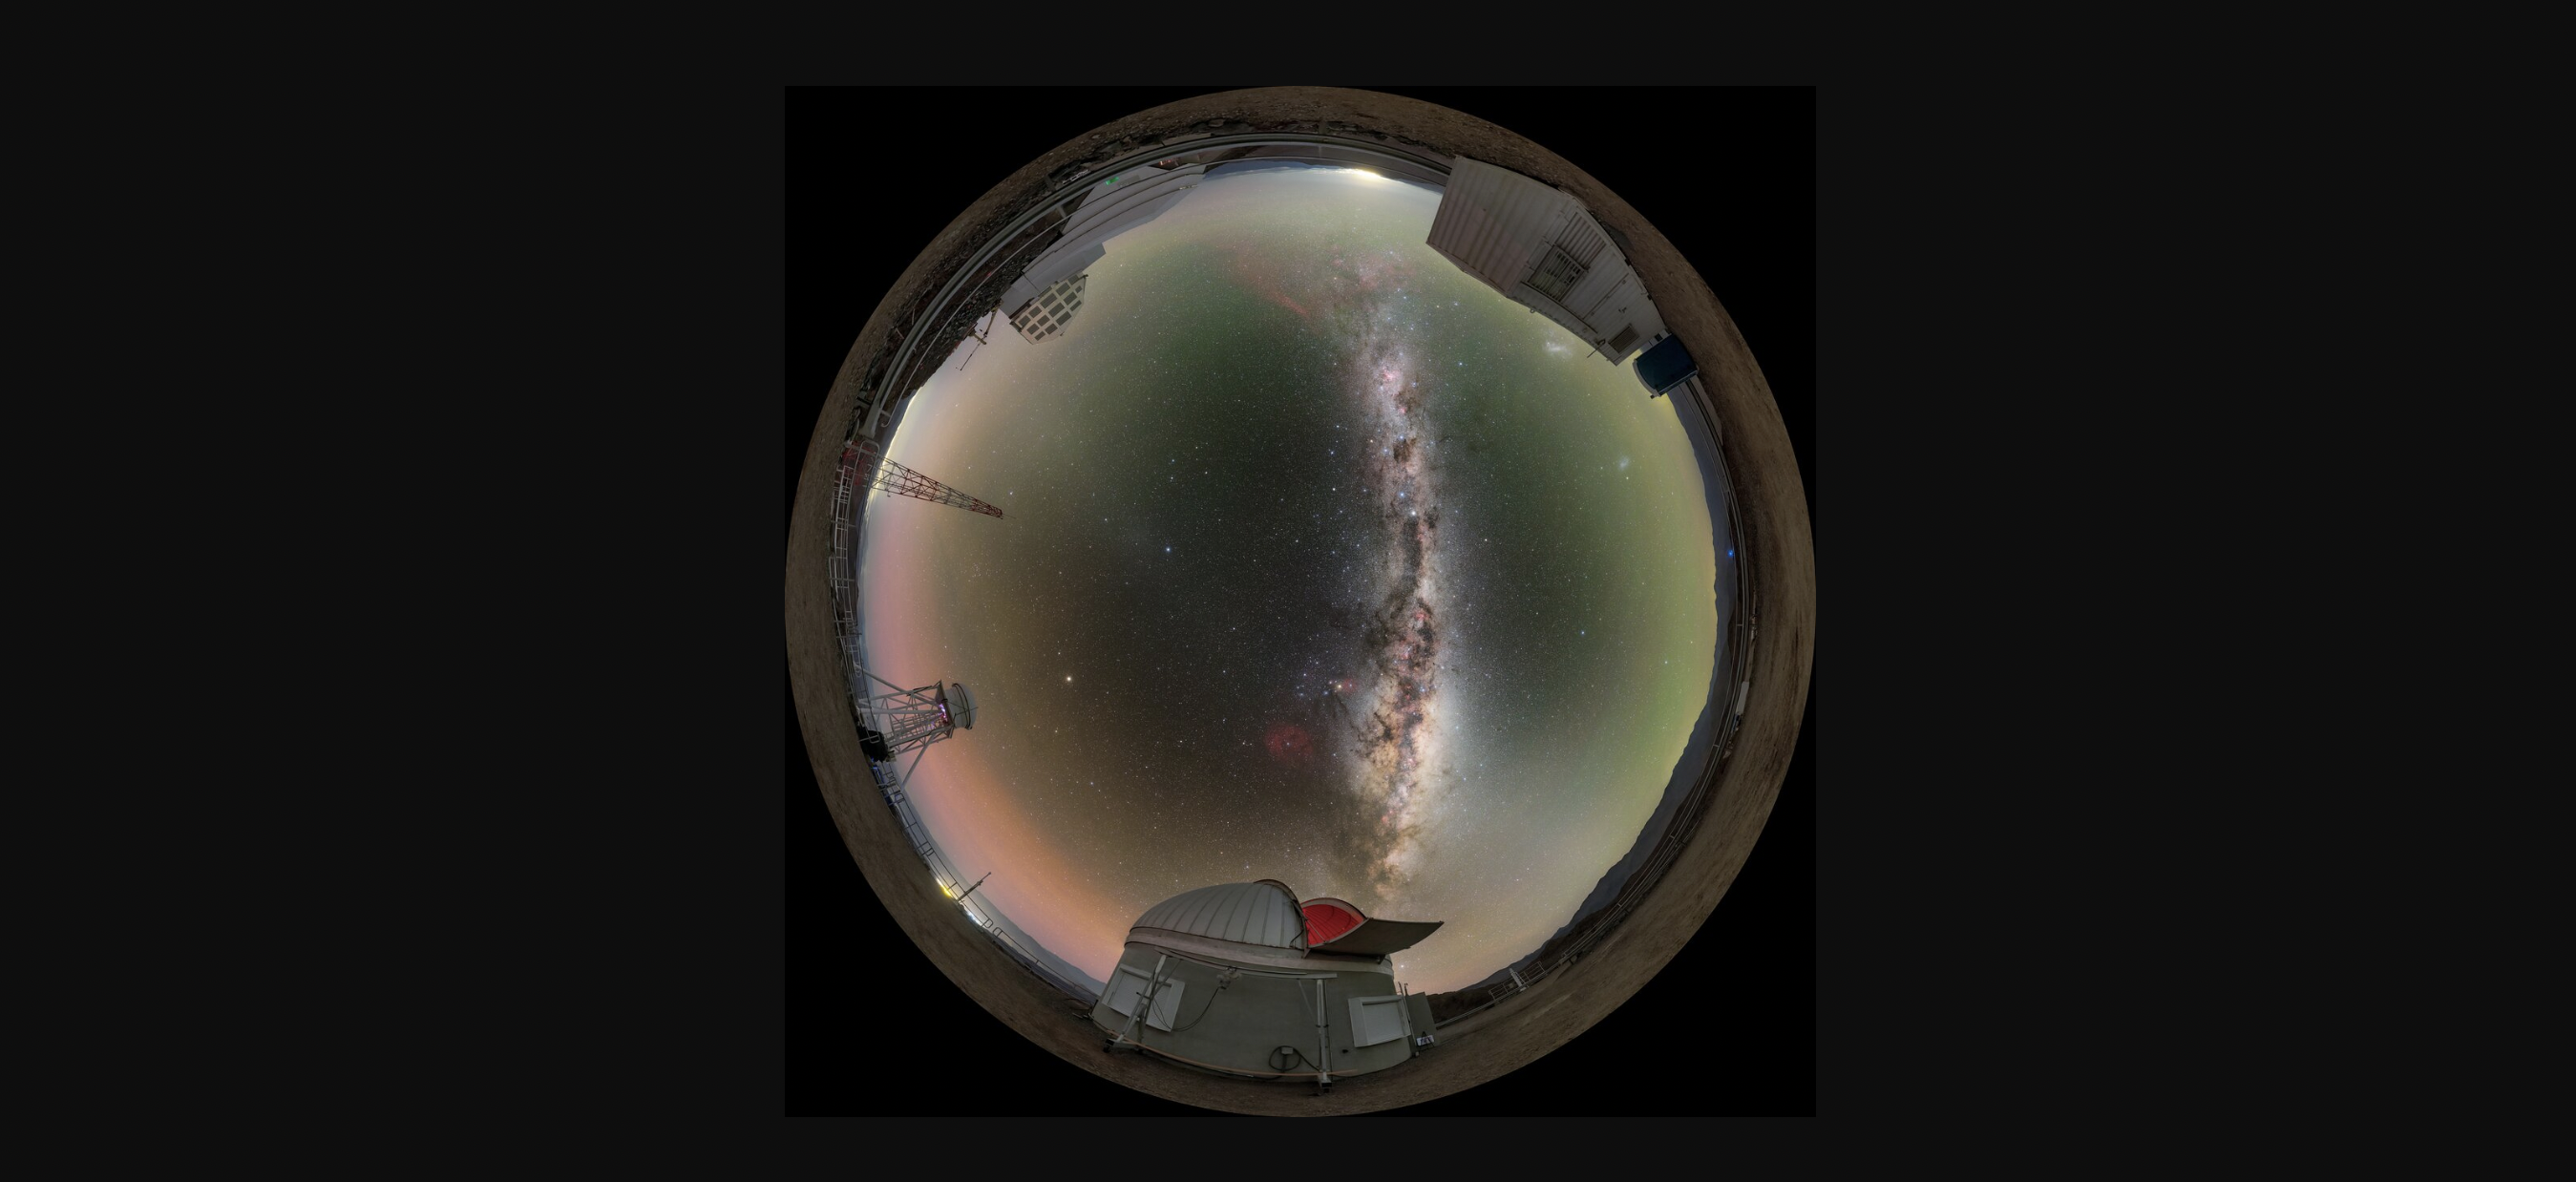

In [2]:
repo_path = "/repo/embargo"
butler = Butler(repo_path)
registry = butler.registry

for c in registry.queryCollections()[:10]:
    print(c)    

LATISS/raw/all
LATISS/calib/DM-28636/curated/19700101T000000Z
LATISS/calib/DM-28636/curated/20180101T000000Z
LATISS/calib/DM-28636/unbounded
refcats/DM-28636
refcats/DM-33444
skymaps
u/czw/DM-28920/biasGen.20210702a/20210702T215049Z
u/czw/DM-28920/darkGen.20210707d/20210707T215331Z
u/czw/DM-28920/defectGen.20210720a/20210720T230634Z


##### We can query the data by date:

In [3]:
expRecords = list(butler.registry.queryDimensionRecords('exposure'))
#expRecords = [r for r in expRecords if 'science' in r.observation_type and str(r.day_obs)[:4] == '2023' and str(r.day_obs)[4:6] == '05']
expRecords = [r for r in expRecords if 'AUXTEL_PHOTO_IMAGING' in r.science_program 
              and str(r.day_obs)[:4] == '2023' 
              and str(r.day_obs)[4:6] == '05' 
              and str(r.day_obs)[6:] == '23']

print(f"Found {len(expRecords)} records")

idlist = [r.id for r in expRecords]

Found 40 records


In [4]:
expRecords = list(butler.registry.queryDimensionRecords('exposure'))
#expRecords = [r for r in expRecords if 'science' in r.observation_type and str(r.day_obs)[:4] == '2023' and str(r.day_obs)[4:6] == '05']
expRecords = [r for r in expRecords if str(r.day_obs)[:4] == '2023' and "SMC" in r.target_name]
              #and str(r.day_obs)[4:6] == '05' 
              #and str(r.day_obs)[6:] == '23']

print(f"Found {len(expRecords)} records")

idlist = [r.id for r in expRecords]

Found 42 records


In [5]:
for r in expRecords:
    print(r.target_name)

SMC_057
SMC_058
SMC_059
SMC_060
SMC_061
SMC_063
SMC_017
SMC_005
SMC_006
SMC_007
SMC_008
SMC_010
SMC_011
SMC_012
SMC_013
SMC_014
SMC_057
SMC_058
SMC_059
SMC_060
SMC_061
SMC_063
SMC_017
SMC_005
SMC_006
SMC_007
SMC_008
SMC_010
SMC_011
SMC_012
SMC_013
SMC_014
SMC_015
SMC_016
SMC_015
SMC_016
SMC_022
SMC_023
SMC_024
SMC_022
SMC_023
SMC_024


In [6]:
print(expRecords[3])

exposure:
  instrument: 'LATISS'
  id: 2023011700131
  physical_filter: 'SDSSr_65mm~empty'
  obs_id: 'AT_O_20230117_000131'
  exposure_time: 30.0
  dark_time: 30.2477
  observation_type: 'science'
  observation_reason: 'object'
  day_obs: 20230117
  seq_num: 131
  seq_start: 131
  seq_end: 132
  group_name: '2023-01-18T00:54:52.615'
  group_id: 2539328926150000
  target_name: 'SMC_060'
  science_program: 'AUXTEL_DRP_IMAGING'
  tracking_ra: 12.686489929355746
  tracking_dec: -72.51740307848223
  sky_angle: 0.008726884425694916
  azimuth: 197.13021748210303
  zenith_angle: 48.89766463794513
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-01-18 00:56:34.409993', scale='tai', format='iso'), end=astropy.time.Time('2023-01-18 00:57:04.658000', scale='tai', format='iso'))


##### Now, we are going to search the raw image collection to pull some of the images from the dates we selected.

In [7]:
collections = ['LATISS/raw/all', 'LATISS/calib']

subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes()[:10]:
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

51895 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
5 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
1 DatasetType('camera', {instrument}, Camera, isCalibration=True)
5 DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
4 DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
23 DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
0 DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog)
0 DatasetType('skyMap', {skymap}, SkyMap)
0 DatasetType('atlas_refcat2_20220201', {htm7}, SimpleCatalog)
0 DatasetType('packages', {}, Packages)


In [8]:
collections = ['LATISS/raw/all', 'LATISS/calib']
datasetRefs = list(subregistry.queryDatasets(
    datasetType='raw',
    collections=collections,
    instrument='LATISS',
    detector=0,
    where = "exposure.id IN (2023011700125) "))

print(len(datasetRefs))

1


In [9]:
collections = ['LATISS/raw/all', 'LATISS/calib']

subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry

def get_image(refid):
    return list(subregistry.queryDatasets( 
                datasetType='raw', 
                collections=collections, 
                instrument='LATISS', 
                detector=0, 
                where = f"exposure.id IN ({refid})"))[0]
def get_raw_image(ref):
    collections = ['LATISS/raw/all', 'LATISS/calib']
    raw=butler.get('raw',dataId = ref.dataId, collections=collections)
    return raw


In [10]:
collections = ['LATISS/raw/all', 'LATISS/calib']
datasetRefs = [get_image(ref.id) for ref in expRecords[0:10]]
raw_images = [get_raw_image(ref) for ref in datasetRefs]
print(len(raw_images))

10


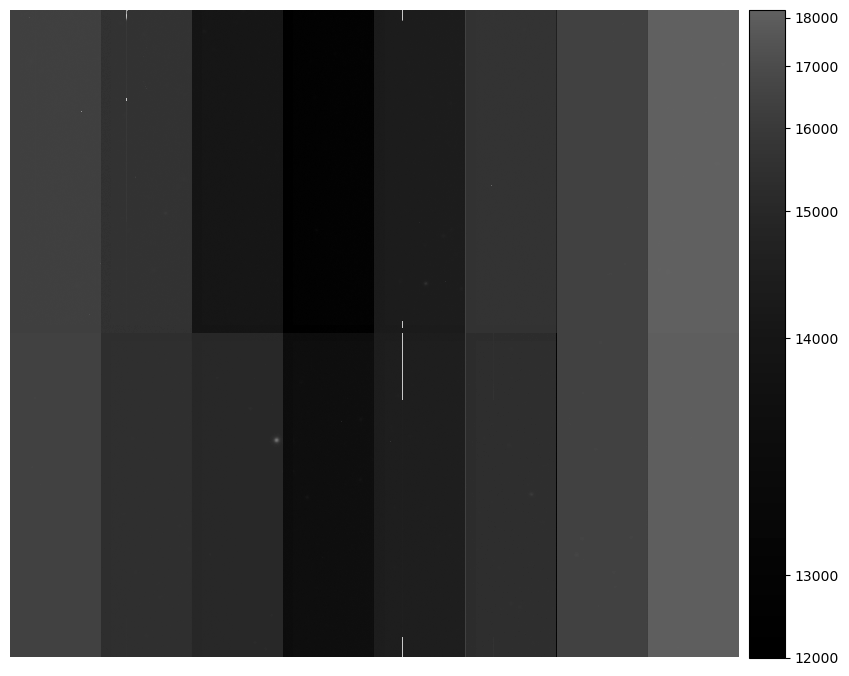

In [11]:
ref = datasetRefs[0]
raw=butler.get('raw',dataId = ref.dataId, collections=collections)

exptime = raw.getMetadata()['EXPTIME']

display(raw)

In [12]:
def isr(raw, bias, dark, defects):
    from lsst.ip.isr.isrTask import IsrTask

    config = IsrTask.ConfigClass()
    config.doDark = True
    config.doBias = True
    config.doFlat = False
    config.doDefect = True
    config.doLinearize=False
    config.doBrighterFatter=False
    config.doApplyGains=False
    config.doOverscan=True
    # The images tend to have serial structure ("banding"), 
    # and this is the best option to remove it.
    config.overscan.fitType='MEDIAN_PER_ROW' 

    isrtask = IsrTask(config=config) # default configuration
    
    postISRStruct = isrtask.run( raw, 
                                camera=camera, 
                                bias=bias, 
                                dark=dark,
                                defects=defects,
                                detectorNum=0)
    # Note: the task returns a struct that contains the exposure object
    image = postISRStruct.exposure
    
    return image

def isr_all(raw_image_list):
    # Get calibrated collections
    collections = "LATISS/calib"
    bias = butler.get('bias',dataId = {"day_obs": 20230131, "seq_num": 151, "detector": 0},instrument='LATISS', collections=collections)
    dark = butler.get('dark',dataId = {"day_obs": 20230523, "seq_num": 45, "detector": 0},instrument='LATISS', collections=collections)
    defects = butler.get('defects',dataId = {"day_obs": 20230523, "seq_num": 45, "detector": 0},instrument='LATISS', collections=collections)
    
    return [isr(raw,bias,dark,defects) for raw in raw_image_list]

In [13]:
corrected_images = isr_all(raw_images)

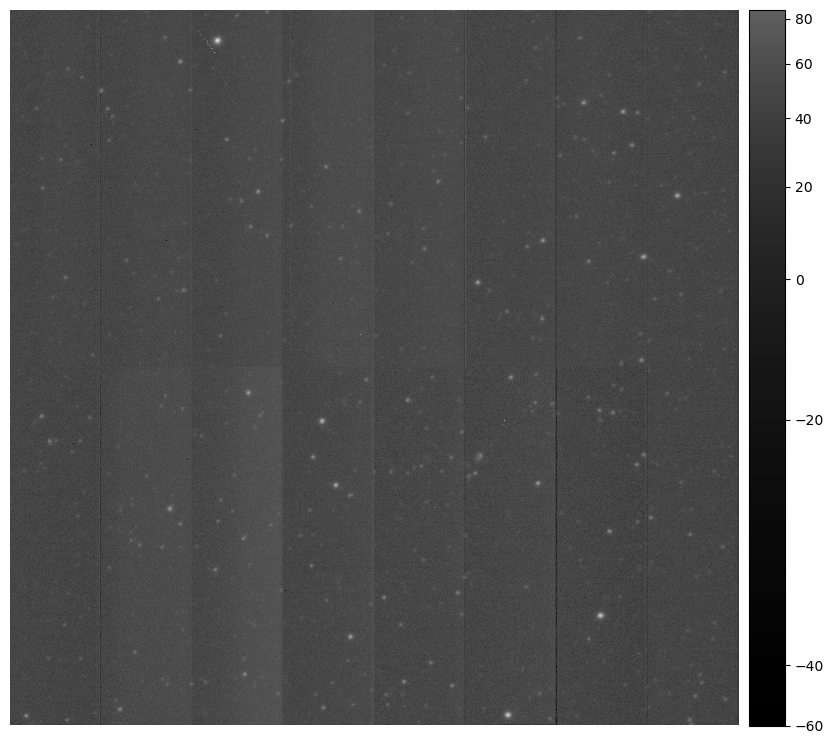

In [14]:
display(corrected_images[4])

1. Identify sources in each image
2. Gernate catalog for each image
3. Compare multiple catalogs for repeated images of the same object within some tolerance

In [15]:
def write_image_to_file(image, pathname):
    image.writeFits(pathname)
    return f"{pathname}.fits"

In [16]:
for i in range(len(corrected_images)):
    write_image_to_file(corrected_images[i], f"./corrected_image_{i}.fits") 

In [17]:
image = corrected_images[0]

In [18]:
image.visitInfo

VisitInfo(exposureTime=30, darkTime=30.2412, date=2023-01-18T00:52:35.879492640, UT1=nan, ERA=2.26688 rad, boresightRaDec=(11.7456556079, -72.5174726216), boresightAzAlt=(197.1042984023, +41.1337324067), boresightAirmass=1.51839, boresightRotAngle=0.000253853 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, nan), instrumentLabel='LATISS', id=2023011700125, focusZ=-0.0123034, observationType='science', scienceProgram='AUXTEL_DRP_IMAGING', observationReason='object', object='SMC_057', hasSimulatedContent=false)

In [19]:
#del corrected_images

In [20]:
def find_stars_in_image(image_fits):
    from astropy.stats import sigma_clipped_stats
    from photutils.datasets import load_star_image
    from photutils.detection import DAOStarFinder

    hdu = fits.open(image_fits)
    data = hdu[1].data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)   

    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources = daofind(data - median)  

    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output
    
    sources.pprint(max_width=76)  
    
    return sources

In [21]:
find_stars_in_image("./corrected_image_0.fits")

 id xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------ -----
  1   1643.74    477.71      0.53      -0.22 ... 0.00    33.51   1.02 -0.02
  2    581.13    536.80      0.76       0.37 ... 0.00    35.92   1.01 -0.01
  3   1085.82    536.83      0.76       0.69 ... 0.00    47.20   1.12 -0.12
  4   1089.94    537.06      0.85       0.56 ... 0.00    50.79   1.08 -0.08
  5   3121.86    537.24      0.76       0.17 ... 0.00    48.49   1.28 -0.27
  6   3125.79    537.11      0.67       0.42 ... 0.00    37.04   1.18 -0.18
  7   3630.93    536.58      0.79       0.31 ... 0.00    49.01   1.27 -0.26
  8    843.21    573.76      0.86       0.40 ... 0.00    55.92   1.02 -0.03
  9    930.94    580.70      0.79      -0.10 ... 0.00    58.00   1.01 -0.01
 10   1440.17    580.99      0.86       0.46 ... 0.00    82.08   1.27 -0.26
...       ...       ...       ...        ... ...  ...      ...    ...   ...
 80    720.9

<QTable length=90>
  id  xcentroid ycentroid sharpness ...   sky     peak     flux    mag  
int64  float64   float64   float64  ... float64 float64  float64 float64
----- --------- --------- --------- ... ------- -------- ------- -------
    1   1643.74    477.71      0.53 ...    0.00    33.51    1.02   -0.02
    2    581.13    536.80      0.76 ...    0.00    35.92    1.01   -0.01
    3   1085.82    536.83      0.76 ...    0.00    47.20    1.12   -0.12
    4   1089.94    537.06      0.85 ...    0.00    50.79    1.08   -0.08
    5   3121.86    537.24      0.76 ...    0.00    48.49    1.28   -0.27
    6   3125.79    537.11      0.67 ...    0.00    37.04    1.18   -0.18
    7   3630.93    536.58      0.79 ...    0.00    49.01    1.27   -0.26
    8    843.21    573.76      0.86 ...    0.00    55.92    1.02   -0.03
    9    930.94    580.70      0.79 ...    0.00    58.00    1.01   -0.01
   10   1440.17    580.99      0.86 ...    0.00    82.08    1.27   -0.26
  ...       ...       ...       ... ...     ...      ...     ...     ...
   81    713.10   3537.33      0.74 ...    0.00   486.24    8.43   -2.32
   82    708.98   3546.73      0.75 ...    0.00   449.17    7.79   -2.23
   83    712.31   3700.68      0.84 ...    0.00   471.17    6.69   -2.06
   84    713.71   3705.14      0.79 ...    0.00   879.37   14.82   -2.93
   85    716.32   3712.66      0.85 ...    0.00   432.96    6.39   -2.01
   86    718.34   3718.87      0.65 ...    0.00   672.22   12.35   -2.73
   87    722.37   3731.05      0.81 ...    0.00   360.54    5.31   -1.81
   88   3802.26   3965.77      0.84 ...    0.00   742.67   12.91   -2.78
   89    974.23   3998.90      0.91 ...    0.00 45426.96  621.15   -6.98
   90   1527.21   3996.99      0.54 ...    0.00    55.90    1.11   -0.12

In [22]:
def get_astropy_wcs_from_image(image):
    from astropy.wcs import WCS
    
    wcs_dict = dict()
    for val in image.getWcs().getFitsMetadata():
        wcs_dict[str(val)] = image.getWcs().getFitsMetadata()[str(val)]

    return WCS(wcs_dict)

def get_astropy_wcs_from_image_file(image_fits):
    from astropy.wcs import WCS
    hdu = fits.open(image_fits)
    wcs = WCS(hdu['SkyWcs'].header)
    hdu.close()
    
    return wcs
    


def find_stars_on_sky(image):
    from astropy.stats import sigma_clipped_stats
    from photutils.datasets import load_star_image
    from photutils.detection import DAOStarFinder
    from astropy.wcs import WCS

    data = image.getImage().getArray()
    wcs = get_astropy_wcs_from_image(image)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)   

    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources = daofind(data - median)  

    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output

    sky_coords = [wcs.pixel_to_world(source['xcentroid'], source['ycentroid']).transform_to('galactic') for source in sources]
    
    sources.add_columns([[c.l for c in sky_coords], [c.b for c in sky_coords]], names=['l (deg)', 'b (deg)'])
    
    #sources.pprint(max_width=76)  
    
    return sources 
    

In [23]:
star_catalog = find_stars_on_sky(corrected_images[0])

In [24]:
star_catalog2 = find_stars_on_sky(corrected_images[1])

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


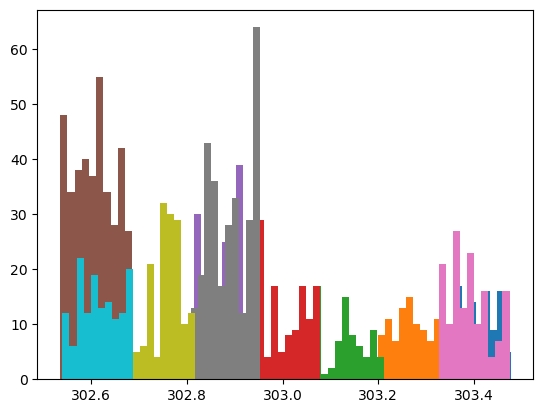

In [25]:
for i, image in enumerate(corrected_images):
    print(f"{i+1}/{len(corrected_images)}")
    star_catalog = find_stars_on_sky(image)
    _ = plt.hist(star_catalog['l (deg)'])


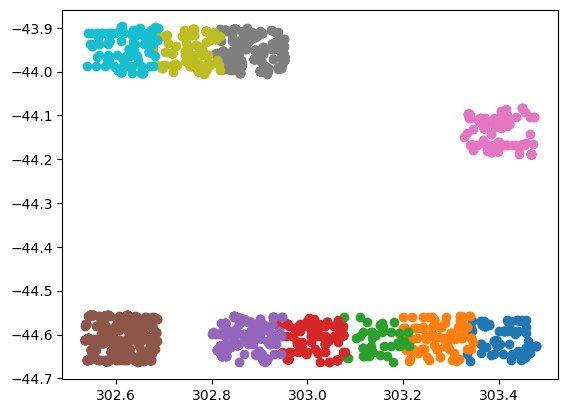

In [26]:
image = corrected_images[0]

wcs = get_astropy_wcs_from_image(image)
for image in corrected_images:
    star_catalog = find_stars_on_sky(image)
    plt.scatter(star_catalog['l (deg)'], star_catalog['b (deg)'])

In [32]:
from reproject.mosaicking import find_optimal_celestial_wcs

wcs_out, shape_out = find_optimal_celestial_wcs([(image.getImage().getArray(), get_astropy_wcs_from_image(image)) for image in corrected_images])

In [33]:
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

In [34]:
#coadd, footprint = reproject_and_coadd([(image.getImage().getArray(), get_astropy_wcs_from_image(image)) for image in corrected_images],
#                                       wcs_out, shape_out=shape_out,
#                                       reproject_function=reproject_interp)
#np.save("./coadd.npy",coadd)
#np.save("./footprint.npy",footprint)


In [36]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from reproject.mosaicking import find_optimal_celestial_wcs


In [ ]:
image1 = corrected_images[0]
image2 = corrected_images[1]
new_image1 = reproject_interp((image1.getImage().getArray(), get_astropy_wcs_from_image(image1)), output_projection=wcs_out, shape_out=shape_out)

In [ ]:
new_image2 = reproject.reproject_interp((image2.getImage().getArray(), get_astropy_wcs_from_image(image2)), output_projection=wcs_out, shape_out=shape_out)

In [2]:
coadd = np.load("./coadd.npy")
#footprint = np.load("./footprint.npy")

In [5]:
print(coadd.shape)


(28883, 25481)
2


In [4]:
! du -sh coadd.py

du: cannot access ‘coadd.py’: No such file or directory


In [ ]:
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(coadd, origin='lower')
#ax1.set_title('Mosaic')
#ax2 = plt.subplot(1, 2, 2)
#im2 = ax2.imshow(footprint, origin='lower')
#ax2.set_title('Footprint')

FITS standard SkyWcs:
Sky Origin: (239.9767113678, -24.0195581165)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel


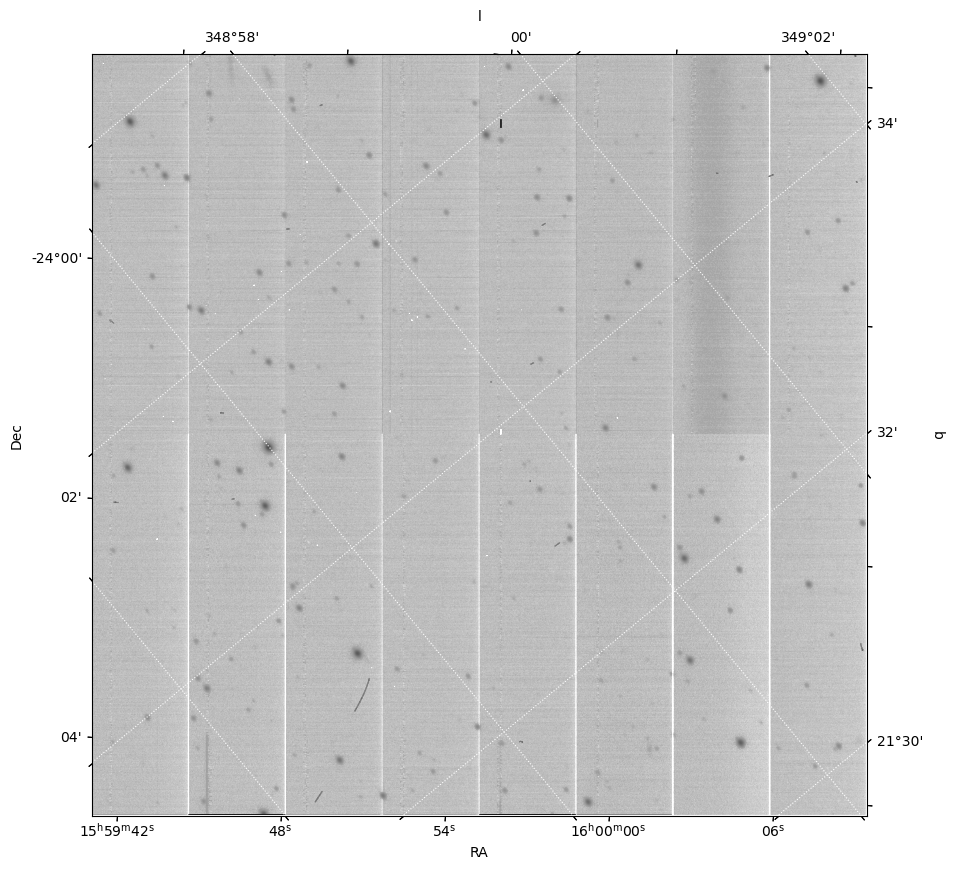

In [18]:
wcs = get_astropy_wcs(image)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
plt.imshow(image.getImage().getArray(), origin='lower', cmap='binary' ,norm=SymLogNorm(10, vmin=-10, vmax=150000, base=10),aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')